In [ ]:
import pyxdf
import numpy as np
import mne
mne.viz.set_browser_backend('matplotlib')  # or 'matplotlib' 'qt', etc.
from utils import read_data, EEGSignalQuality, parse_xdf
import os
import glob
import matplotlib.pyplot as plt
matplotlib.style.use('default')
%matplotlib qt

In [ ]:
exp_path = os.path.join("exp_data", "02_Experimental")
control_path = os.path.join("exp_data", "01_Control")
glob_pattern = os.path.join("**", "*.xdf")

In [ ]:
def list_xdf_files(base_path, pattern=glob_pattern, exclude_substr='-old'):
    """Return list of .xdf files under base_path excluding any path that contains exclude_substr."""

    files = glob.glob(os.path.join(base_path, pattern), recursive=True)

    return [f for f in files if exclude_substr not in f]


def build_combined_mapping(exp_path, control_path, pattern=glob_pattern, exclude_substr='-old'):
    """Return combined mapping with keys 'exp' and 'control'.

    Each maps EXP/CTRL folder name -> chosen file path.

    """

    exp_files = list_xdf_files(
        exp_path, pattern=pattern, exclude_substr=exclude_substr)
    control_files = list_xdf_files(
        control_path, pattern=pattern, exclude_substr=exclude_substr)

    combined = {'exp': {}, 'control': {}}

    for f in exp_files:

        parts = f.split(os.sep)

        exp_folder = next((p for p in parts if p.startswith('EXP')), None)

        if exp_folder:

            combined['exp'][exp_folder] = f

    for f in control_files:

        parts = f.split(os.sep)

        ctrl_folder = next((p for p in parts if p.startswith('CTRL')), None)

        if ctrl_folder:

            combined['control'][ctrl_folder] = f

    return combined


# Build combined mapping and keep backward-compatible dicts
combined = build_combined_mapping(exp_path, control_path)
exp_dict = combined['exp']
control_dict = combined['control']
combined

In [27]:
import pyxdf
subject = control_dict['CTRL16']
print(f"Reading data for subject: {subject}")
# data = pyxdf.load_xdf(subject)
# flat_voltage=None, bandpass=None
raw, events, mapping = read_data(
    subject, eeg_stream_name='obci_eeg2', flat_voltage=None, bandpass=None)
raw

Reading data for subject: exp_data/01_Control/CTRL16/sub-540007/sub-540007_task-hearing_run-001.xdf
Creating RawArray with float64 data, n_channels=16, n_times=166155
    Range : 0 ... 166154 =      0.000 ...  1329.232 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 s)

Creating RawArray with float64 data, n_channels=16, n_times=166155
    Range : 0 ... 166154 =      0.000 ...  1329.232 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from

<RawArray | 16 x 166155 (1329.2 s), ~20.3 MiB, data loaded>

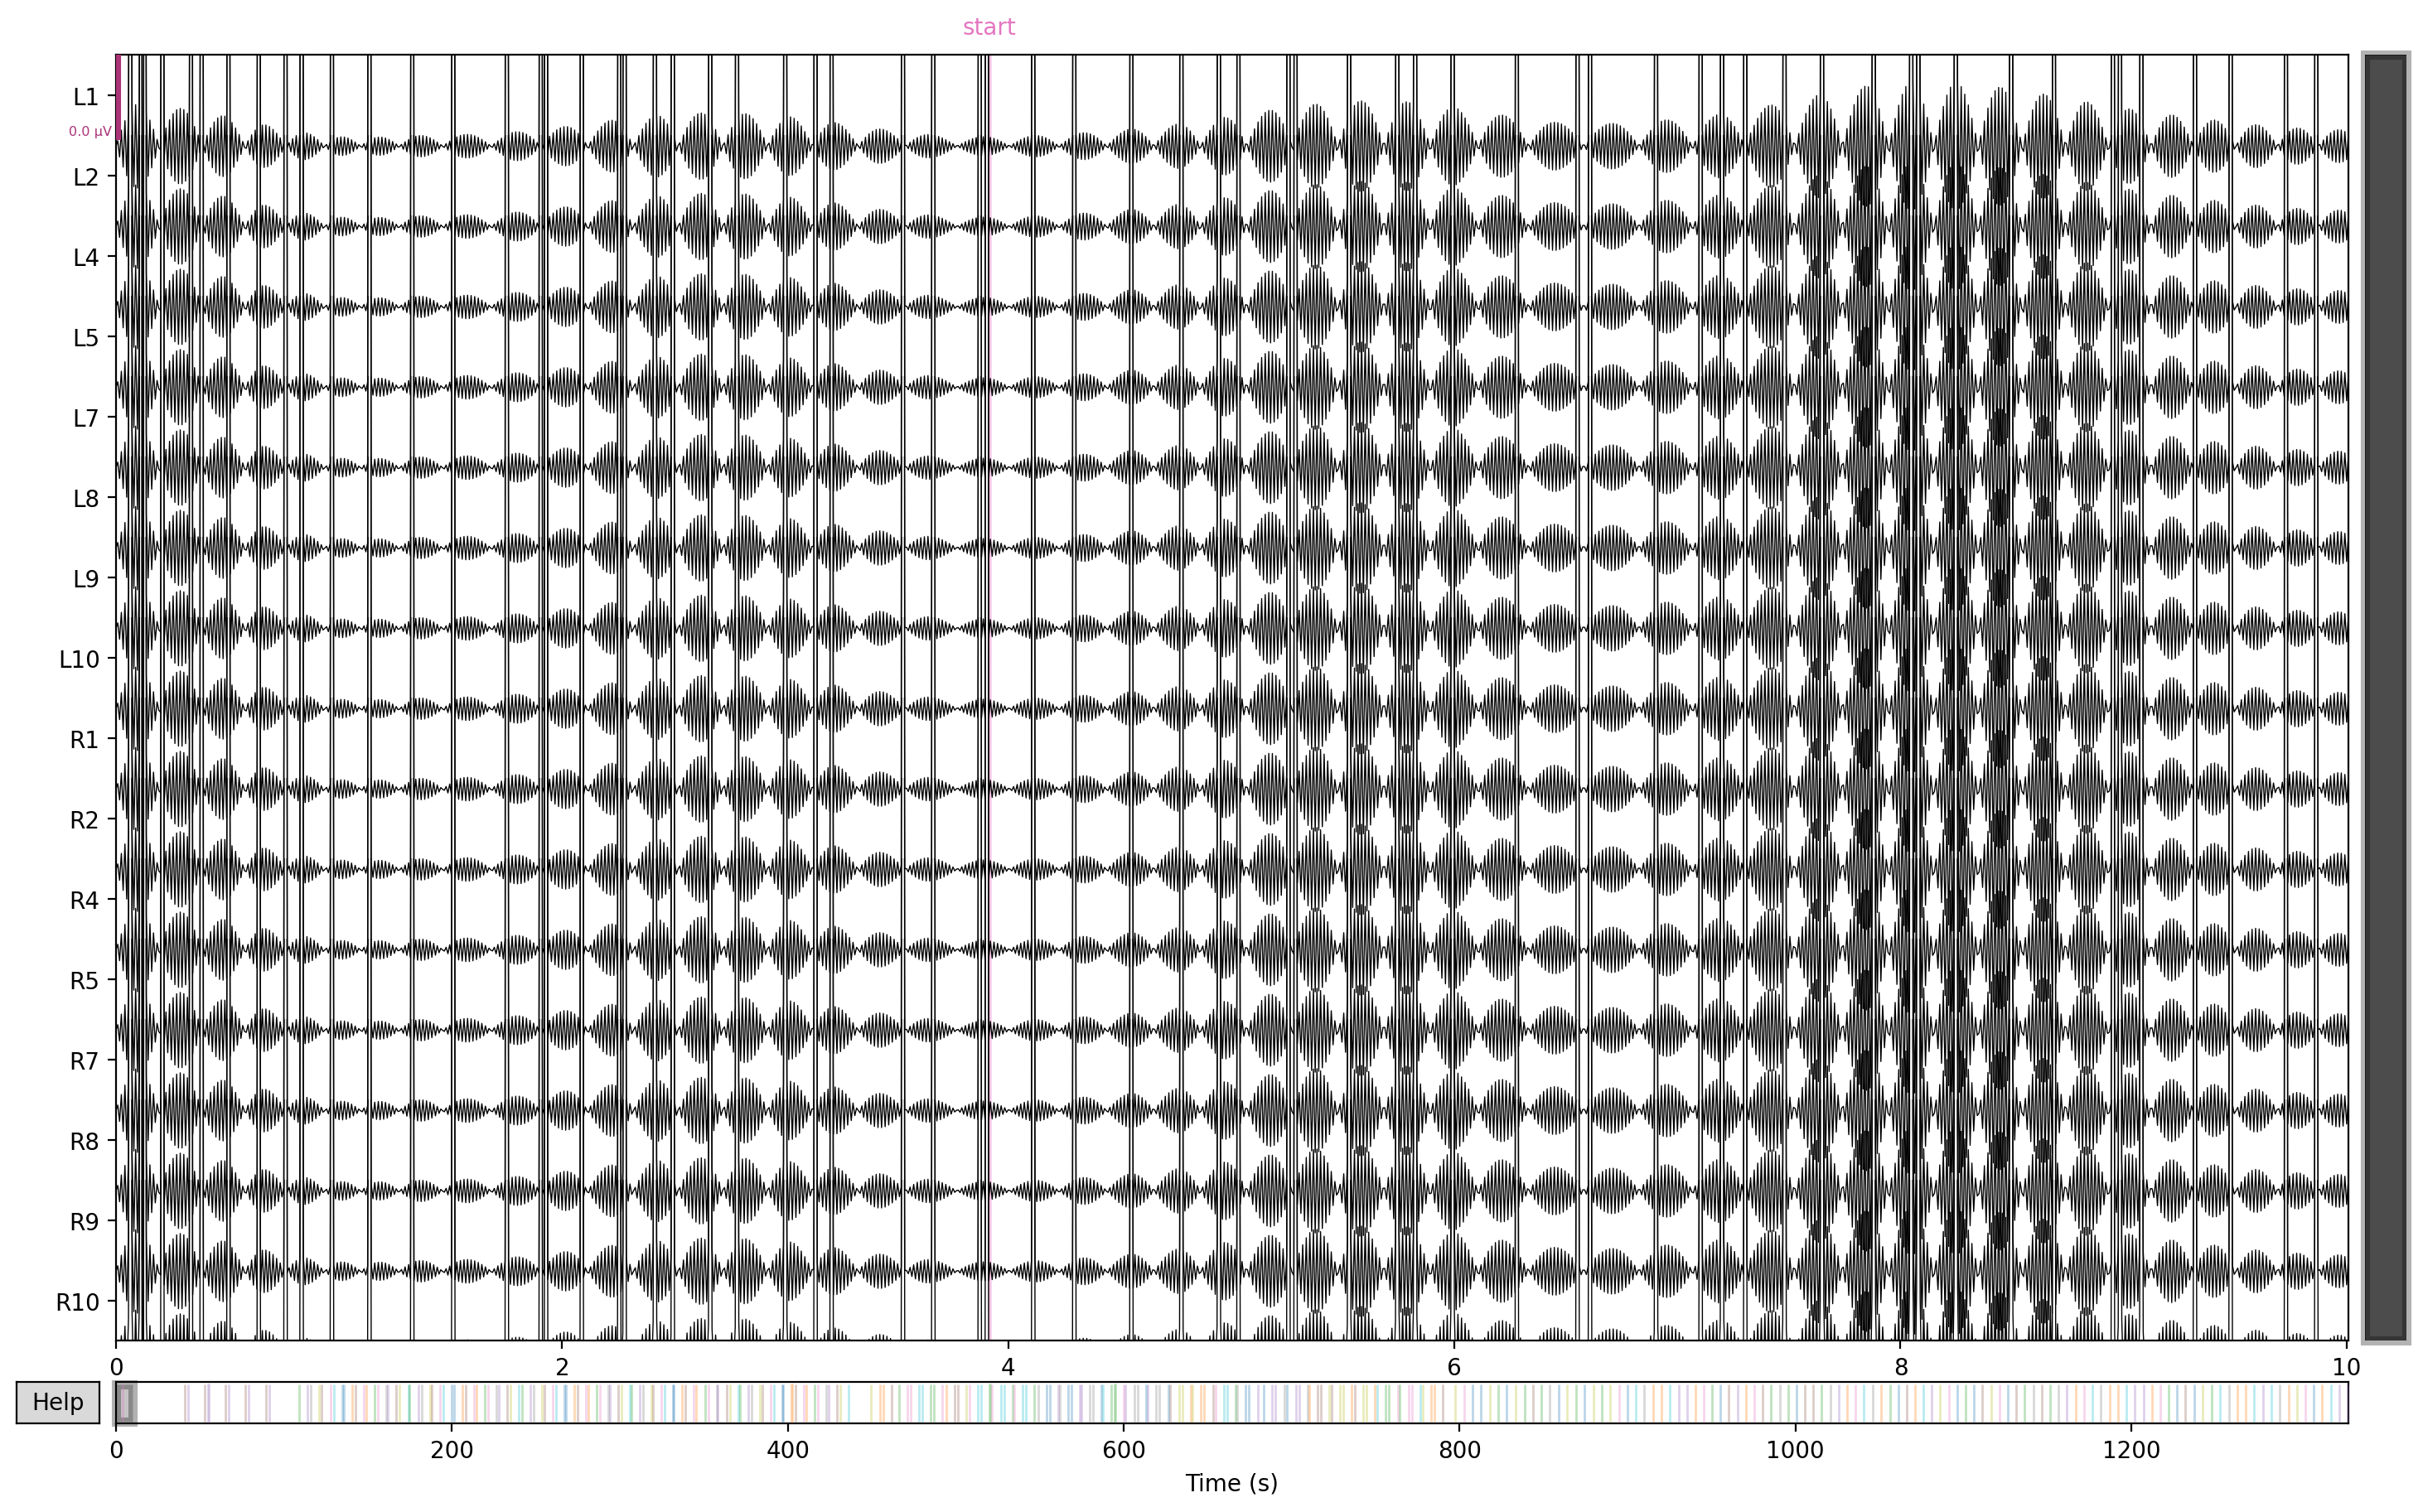

In [28]:
raw.plot(scalings='auto')

In [ ]:
mapping['ast']['stim']

In [ ]:
ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
                 'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
quality_analyzer = EEGSignalQuality(raw, ch_labels, None)
results = quality_analyzer.comprehensive_quality_assessment(None)

In [ ]:
# Print summary
for summary in results["quality_summary"]:
    print(
        f"Channel {summary['channel']}: {summary['quality_grade']} (Score: {summary['overall_score']:.3f})"
    )